In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

%matplotlib inline

## Load Data

In [2]:
company = pd.read_csv("../data/Diversity in the Workplace/HR/company_hierarchy.csv")
employee = pd.read_csv("../data/Diversity in the Workplace/HR/employee.csv")

In [3]:
company.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [4]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
employee_id    10000 non-null int64
boss_id        9999 non-null float64
dept           10000 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 234.4+ KB


In [5]:
company.loc[company['boss_id'].isnull()]

,employee_id,boss_id,dept
2427,61554,NaN,CEO


In [6]:
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [7]:
data = pd.merge(employee, company, on = 'employee_id', how = 'left')
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


## Question 1: 
In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

In [8]:
hierachy = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
data['job_title'] = 0
data.loc[data['boss_id'].isnull(), 'job_title'] = 'CEO'

for i in range(1, len(hierachy)):
    boss = data.loc[data['job_title'] == hierachy[i-1], 'employee_id']
    data.loc[data['boss_id'].isin(boss), 'job_title'] = hierachy[i]

In [9]:
data.groupby('job_title', as_index = False).agg({'employee_id': 'count'}).rename(columns={'employee_id': 'employee_id_count'}).sort_values('employee_id_count', ascending = False)

,job_title,employee_id_count
3,IC,9000
4,MM,800
1,D,160
5,VP,35
2,E,4
0,CEO,1


## Question 2:
How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [10]:
hierachy_reversed = hierachy[::-1]
data['count'] = 0

for i in range(1, len(hierachy)):
    for b in data.loc[data['job_title'] == hierachy[i], 'employee_id']:
        employee = data.loc[data['boss_id'] == b, 'count'] + 1
        data.loc[data['employee_id'] == b, 'count'] = sum(employee)

In [11]:
data.loc[data['employee_id'] == 141211]

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,job_title,count
2625,141211,0,60000.0,High_School,M,9,116660.0,HR,MM,7


## Question 3 Build a model to predict the salary of each employee.
EDA and then build a model

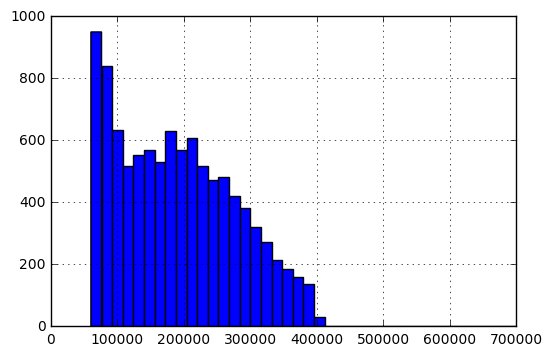

In [12]:
data.salary.hist(bins=40)

Salary is highly right skewed. Log transformed to make it more balanced.

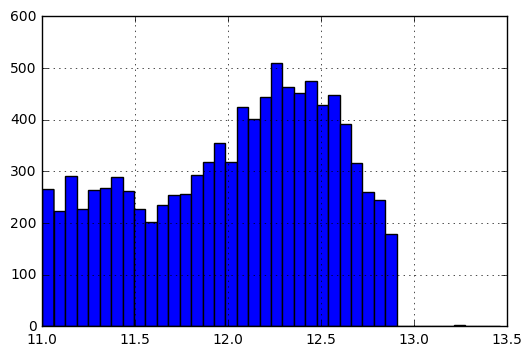

In [13]:
data['log_salary'] = np.log(data['salary'])
data.log_salary.hist(bins = 40)

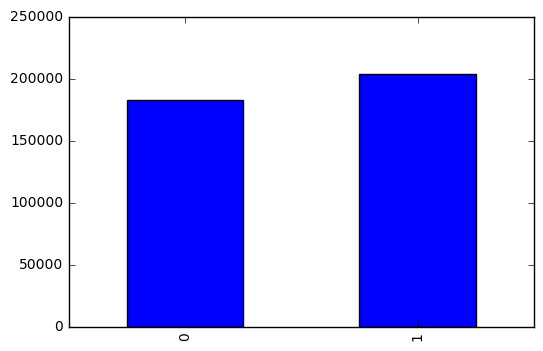

In [14]:
# sns.countplot(x= 'signing_bonus', data = data)
# sns.barplot(x='signing_bonus', y = 'salary', data = data)
grouped = data.groupby('signing_bonus', as_index = False).agg({'employee_id': 'count', 'salary': 'mean'})
grouped['salary'].plot(kind='bar')
# plt.bar(grouped['signing_bonus'],grouped['employee_id'])

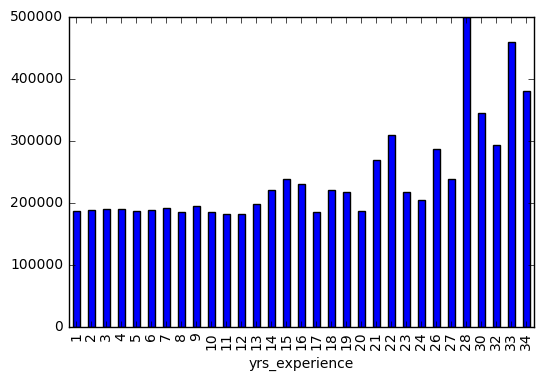

In [15]:
# sns.barplot(x='yrs_experience', y = 'salary', data = data, estimator=np.mean)
grouped = data.groupby('yrs_experience').agg({'salary': 'mean', 'employee_id': 'count'}).rename({'salary': 'mean_salary'})
grouped['salary'].plot(kind='bar')

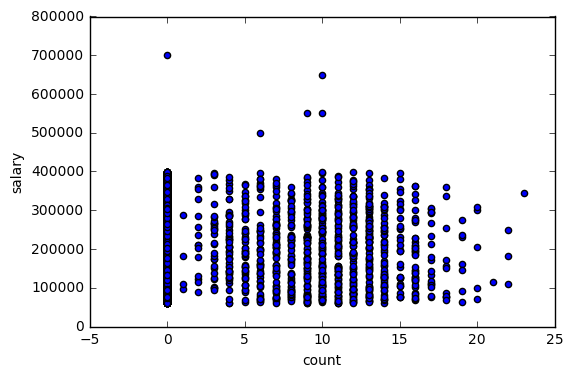

In [16]:
# sns.jointplot(x='count', y = 'salary',data = data)
data.plot(x='count', y = 'salary', kind = 'scatter')

## Feature Eng

In [17]:
# Categorical features
data = pd.get_dummies(data, prefix = 'dept', columns = ['dept'], drop_first = True)
data = pd.get_dummies(data, prefix = 'sex', columns = ['sex'], drop_first = True)

In [18]:
# Ordered categorical features
def degree2number(x):
    degrees = ['High_School','Bachelor','Master','PhD']
    for i in range(len(degrees)):
        if x == degrees[i]:
            return i
data['degreeNumber'] = data['degree_level'].apply(degree2number)

## Build Model

In [19]:
feature_list = data.columns.drop([u'employee_id',u'salary', u'boss_id', u'job_title',u'log_salary', u'degree_level'])

In [20]:
train, test = train_test_split(data, test_size = 0.3)
train_X = train[feature_list]
train_y = train['log_salary']
test_x = test[feature_list]
test_y = test['log_salary']

### XGBoost

In [21]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')
xg_reg.fit(train_X,train_y)

preds = xg_reg.predict(test_x)
print 'The XGBoost RMSE: ', np.sqrt(mean_squared_error(test_y,preds))

The XGBoost RMSE:  0.39158635719


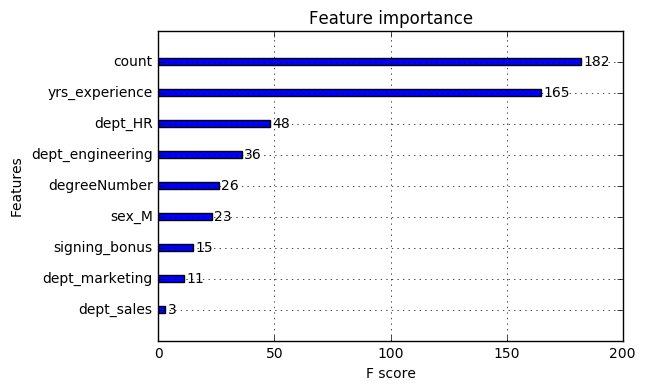

In [22]:
xgb.plot_importance(xg_reg)

### Random Forest Regression

In [23]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(train_X,train_y)

preds = model.predict(test_x)
print 'The Random Forest RMSE: ', np.sqrt(mean_squared_error(test_y,preds))

The Random Forest RMSE:  0.405649583474


In [24]:
model.plot_importance(xg_reg)

AttributeError: 'RandomForestRegressor' object has no attribute 'plot_importance'

### XGBoost

In [28]:
train_matrix = xgb.DMatrix(train_X,train_y)
test_matrix = xgb.DMatrix(test_x)

In [29]:
# watchlist = [(train_matrix, 'train')]
params = {'silent': 1, 'objective': 'reg:linear', 'eval_metric':'rmse', 
          'num_rounds': 300, 'early_stopping_rounds':30, 'eta':0.1, 'subsample':0.8}

n_best_trees = 51
gbt = xgb.train(params, train_matrix, n_best_trees)

In [30]:
ytest_pred = gbt.predict(test_matrix, ntree_limit=n_best_trees)
np.sqrt(mean_squared_error(test_y,ytest_pred))

0.39804148110165394

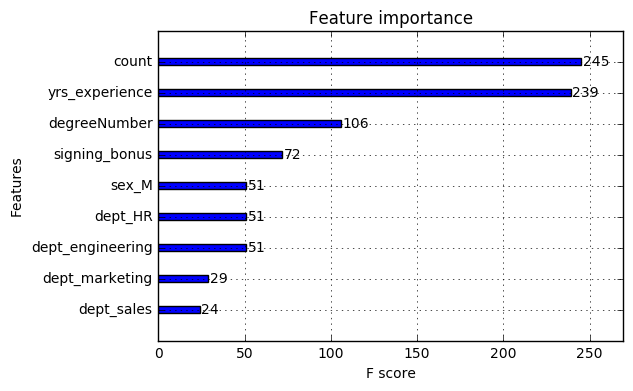

In [31]:
xgb.plot_importance(gbt)